In [1]:
# necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import pandas as pd
import seaborn as sns

import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

import glob

import torch.optim as optim
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
import ipywidgets as widgets
from IPython.display import display,clear_output
from PIL import Image
import io

# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import cv2

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [2]:
! unzip /content/archive.zip
! rm /content/TB_Chest_Radiography_Database/Normal.metadata.xlsx
! rm /content/TB_Chest_Radiography_Database/README.md.txt
! rm /content/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx

Archive:  /content/archive.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1009.png  
  inflating: TB_Chest_Rad

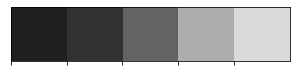

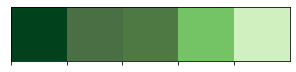

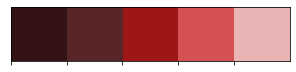

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
labels = ['Tuberculosis','Normal']

In [5]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/TB_Chest_Radiography_Database/',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 3500/3500 [00:22<00:00, 154.01it/s]


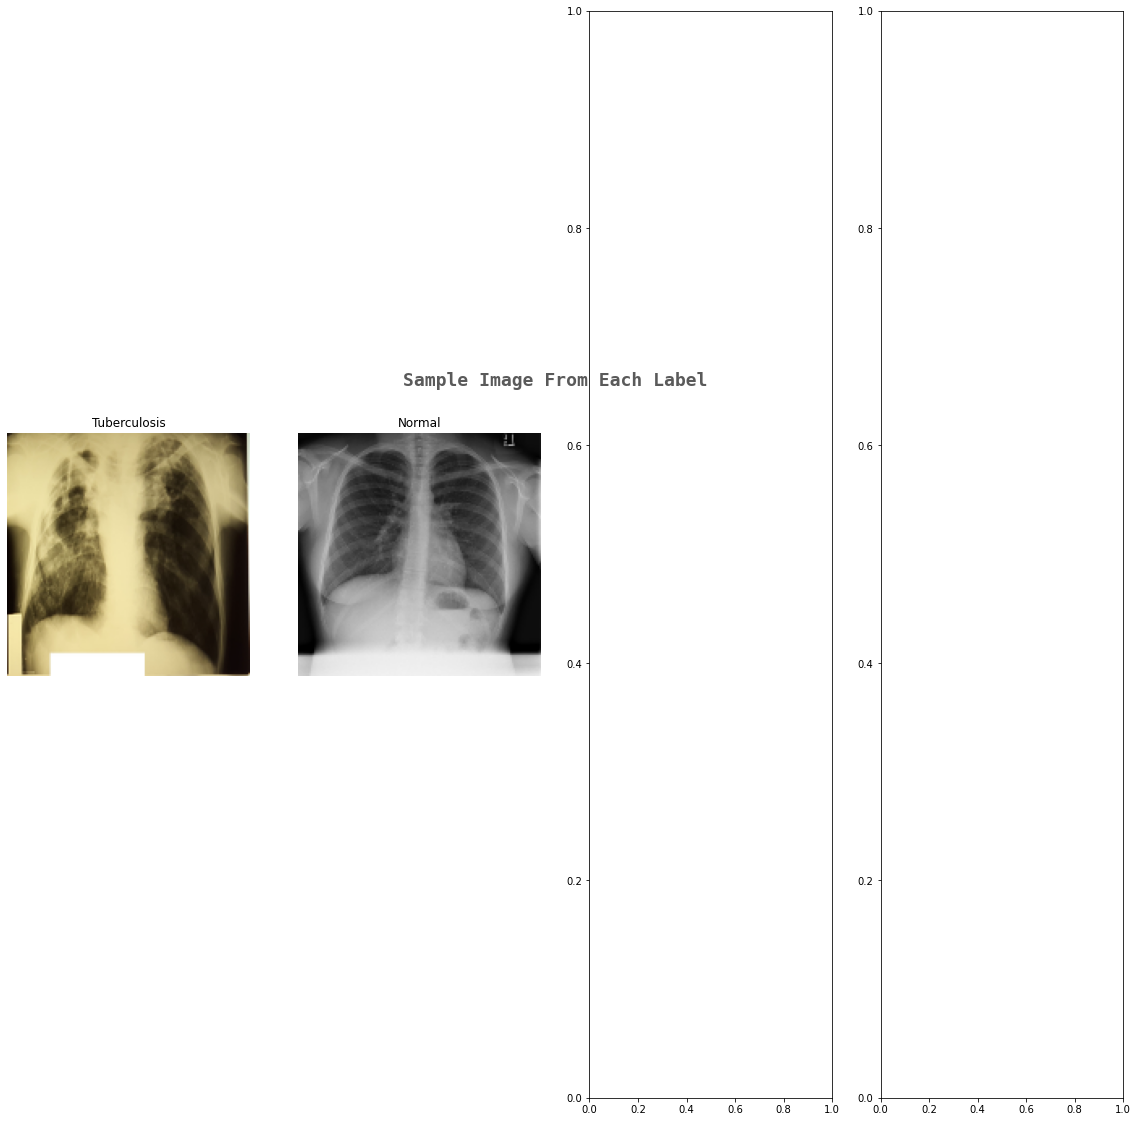

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [11]:
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

In [12]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("tuberculosis.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [13]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
107/107 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9747
Epoch 1: val_accuracy improved from -inf to 0.96296, saving model to effnet.h5
107/107 [==============================] - 386s 4s/step - loss: 0.0636 - accuracy: 0.9747 - val_loss: 0.0874 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 2/12
107/107 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9979
Epoch 2: val_accuracy did not improve from 0.96296
107/107 [==============================] - 365s 3s/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.8622 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 3/12
107/107 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9932
Epoch 3: val_accuracy improved from 0.96296 to 0.99735, saving model to effnet.h5
107/107 [==============================] - 370s 3s/step - loss: 0.0180 - accuracy: 0.9932 - val_loss: 0.0117 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 4/12
107/107 [==============================] - ETA: 0s - l

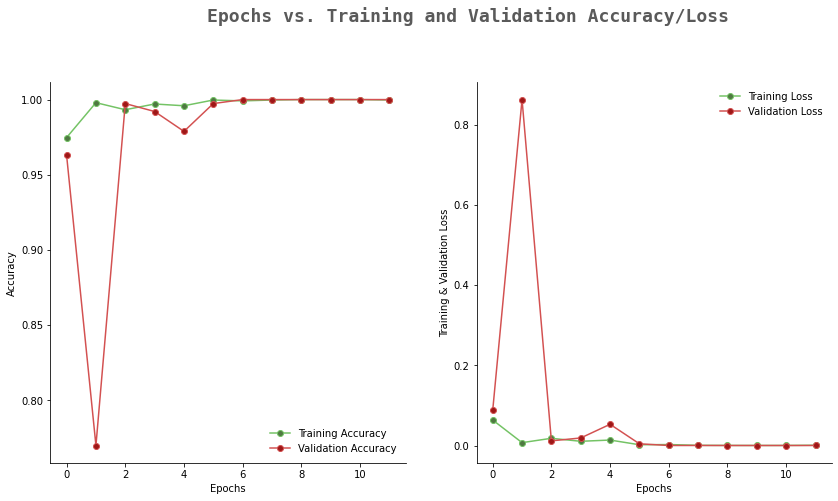

In [14]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [15]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [16]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      1.00      1.00       349

    accuracy                           1.00       420
   macro avg       0.99      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



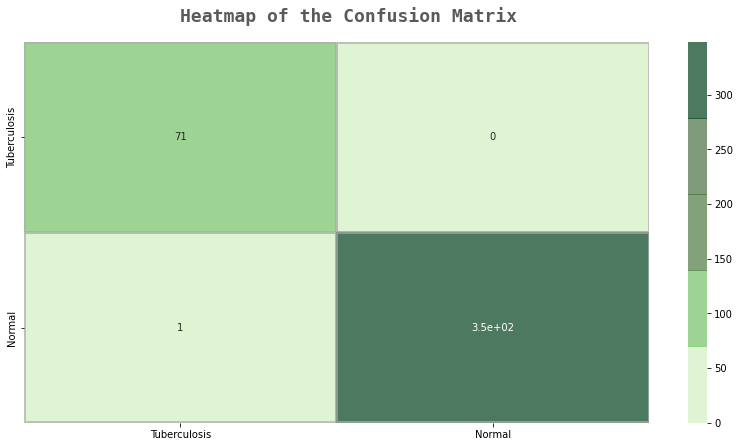

In [17]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [30]:
def img_pred():
    #UPLOAD IMAGE IN THE QUOTATION MARKS
    img = Image.open(("/content/test.jpg"))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Tuberculosis is present'
    elif p==1:
        p='Tuberculosis is NOT present'

    print(f'The Model predicts that {p}')

img_pred()

The Model predicts that Tuberculosis is present
